# Stroke Prediction using Bayesian Networks
This notebook demonstrates Bayesian Network modeling, parameter learning, and inference on a healthcare dataset to predict stroke risk.

In [1]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt
import networkx as nx
import os 
save_path = "../images"
os.makedirs(save_path, exist_ok=True)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Load and preprocess data
We load the stroke dataset, remove unnecessary columns, handle missing values, and discretize numeric features.

In [3]:
data = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")

# Drop ID column
data = data.drop('id', axis=1)

# Fill missing values
data['bmi'] = data['bmi'].fillna(data['bmi'].median())
data['smoking_status'] = data['smoking_status'].fillna('Unknown')

# Discretize continuous variables
data['age'] = pd.cut(data['age'], bins=3, labels=['Young', 'Middle', 'Old'])
data['bmi'] = pd.cut(data['bmi'], bins=3, labels=['Normal', 'Overweight', 'Obese'])
data['avg_glucose_level'] = pd.cut(data['avg_glucose_level'], bins=3, labels=['Low', 'Medium', 'High'])

print("Prepared dataset:")
print(data.head())

Prepared dataset:
   gender     age  hypertension  heart_disease ever_married      work_type  \
0    Male     Old             0              1          Yes        Private   
1  Female     Old             0              0          Yes  Self-employed   
2    Male     Old             0              1          Yes        Private   
3  Female  Middle             0              0          Yes        Private   
4  Female     Old             1              0          Yes  Self-employed   

  Residence_type avg_glucose_level     bmi   smoking_status  stroke  
0          Urban              High  Normal  formerly smoked       1  
1          Rural              High  Normal     never smoked       1  
2          Rural               Low  Normal     never smoked       1  
3          Urban            Medium  Normal           smokes       1  
4          Rural            Medium  Normal     never smoked       1  


## Step 2: Define Bayesian Network structure
We manually define the network structure connecting features to the target variable `stroke`.

In [4]:
model = BayesianNetwork([
    ('age', 'stroke'),
    ('hypertension', 'stroke'),
    ('heart_disease', 'stroke'),
    ('avg_glucose_level', 'stroke'),
    ('bmi', 'stroke'),
    ('smoking_status', 'stroke')
])

print("\nNetwork structure (edges):")
print(model.edges())


Network structure (edges):
[('age', 'stroke'), ('hypertension', 'stroke'), ('heart_disease', 'stroke'), ('avg_glucose_level', 'stroke'), ('bmi', 'stroke'), ('smoking_status', 'stroke')]


## Step 3: Learn parameters using Maximum Likelihood Estimation
The CPDs (Conditional Probability Distributions) are estimated from the data.

In [5]:
model.fit(data, estimator=MaximumLikelihoodEstimator)

print("\nLearned CPDs:")
for cpd in model.get_cpds():
    print(cpd)


Learned CPDs:
+-------------+----------+
| age(Middle) | 0.37593  |
+-------------+----------+
| age(Old)    | 0.348141 |
+-------------+----------+
| age(Young)  | 0.27593  |
+-------------+----------+
+-------------------+-----+---------------------------+
| age               | ... | age(Young)                |
+-------------------+-----+---------------------------+
| avg_glucose_level | ... | avg_glucose_level(Medium) |
+-------------------+-----+---------------------------+
| bmi               | ... | bmi(Overweight)           |
+-------------------+-----+---------------------------+
| heart_disease     | ... | heart_disease(1)          |
+-------------------+-----+---------------------------+
| hypertension      | ... | hypertension(1)           |
+-------------------+-----+---------------------------+
| smoking_status    | ... | smoking_status(smokes)    |
+-------------------+-----+---------------------------+
| stroke(0)         | ... | 0.5                       |
+-----------

## Step 4: Inference using Variable Elimination
We calculate the probability of stroke for specific evidence scenarios.

In [6]:
infer = VariableElimination(model)

# Example 1: Old person with hypertension
q1 = infer.query(variables=['stroke'], evidence={'age': 'Old', 'hypertension': 1})
print("\nProbability of stroke for elderly with hypertension:")
print(q1)

# Example 2: Smoker with high glucose
q2 = infer.query(variables=['stroke'], evidence={'smoking_status': 'smokes', 'avg_glucose_level': 'High'})
print("\nProbability of stroke for smoker with high glucose level:")
print(q2)


Probability of stroke for elderly with hypertension:
+-----------+---------------+
| stroke    |   phi(stroke) |
+===========+===============+
| stroke(0) |        0.8588 |
+-----------+---------------+
| stroke(1) |        0.1412 |
+-----------+---------------+

Probability of stroke for smoker with high glucose level:
+-----------+---------------+
| stroke    |   phi(stroke) |
+===========+===============+
| stroke(0) |        0.9255 |
+-----------+---------------+
| stroke(1) |        0.0745 |
+-----------+---------------+


## Step 5: Visualize Bayesian Network
We plot the network structure using NetworkX.

/var/folders/fc/t6pcltjn1fs27lnkc9qqd1l40000gn/T/ipykernel_16628/3437881422.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


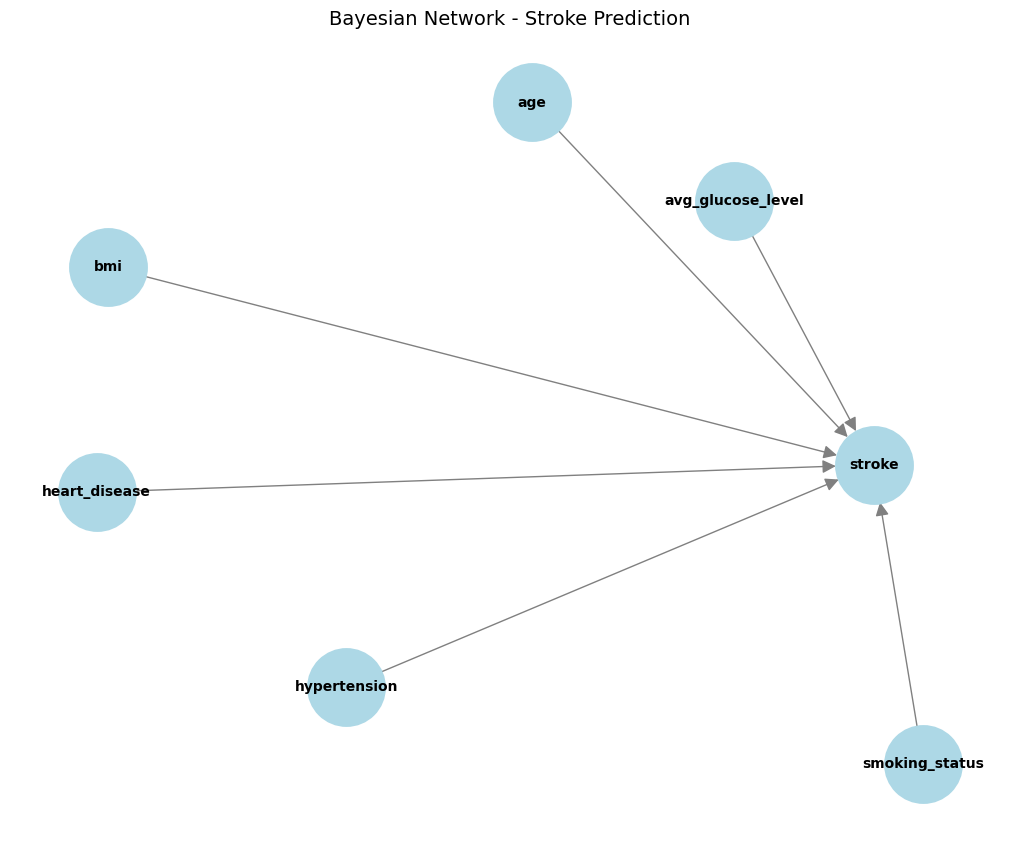

In [7]:
plt.figure(figsize=(10, 8))
G = nx.DiGraph(model.edges())
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', 
        font_size=10, font_weight='bold', arrows=True, arrowsize=20, 
        edge_color='gray', linewidths=2)
plt.title("Bayesian Network - Stroke Prediction", fontsize=14)
plt.tight_layout()
plt.savefig(f"{save_path}/Network.png", dpi=300)
plt.show()